In [1]:

#import xml.etree.ElementTree as ET
#import defusedxml.ElementTree as ET


#from collections import OrderedDict
#import collections
#from collections import Counter

import os
import pickle
import glob
import gzip
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
#MeSH 読込
with open('mesh_list_2021.pickle', 'rb') as f:
    mesh_list = pickle.load(f)

#メッシュから　メッシュIDと疾患/症状メッシュ、TreeNumber を取り出す
#疾患メッシュ：Cのうち C22（動物)とC23.888（症状）を除外したもの）＋F03（精神障害）
#症状メッシュ：C23.888
mesh_diseases = [descriptor for descriptor in tqdm(mesh_list) for uid in descriptor[-1] if ((uid.startswith("C")==True) & (uid.startswith("C22")!=True)&(uid.startswith("C23.888")!=True)) | (uid.startswith("F03")==True) ]
mesh_symptoms = [descriptor for descriptor in tqdm(mesh_list)  for uid in descriptor[-1] if (uid.startswith("C23.888")==True)]
#さらにメッシュ名だけにする＋重複削除
mesh_diseases= pd.DataFrame(mesh_diseases)[1].drop_duplicates(keep='last').reset_index(drop=True).values.tolist()
mesh_symptoms= pd.DataFrame(mesh_symptoms)[1].drop_duplicates(keep='last').reset_index(drop=True).values.tolist()

len(mesh_list),len(mesh_diseases), len(mesh_symptoms)

<ipython-input-2-653cf2ddb605>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  mesh_diseases = [descriptor for descriptor in tqdm(mesh_list) for uid in descriptor[-1] if ((uid.startswith("C")==True) & (uid.startswith("C22")!=True)&(uid.startswith("C23.888")!=True)) | (uid.startswith("F03")==True) ]


  0%|          | 0/29917 [00:00<?, ?it/s]

<ipython-input-2-653cf2ddb605>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  mesh_symptoms = [descriptor for descriptor in tqdm(mesh_list)  for uid in descriptor[-1] if (uid.startswith("C23.888")==True)]


  0%|          | 0/29917 [00:00<?, ?it/s]

(29917, 4887, 394)

In [6]:
os.chdir('/home/admin_user/デスクトップ/data')
df = pd.read_csv("pmid_ds_pair_m2021.csv")

In [7]:
#共起ペアと共起数
co_occ_pair = pd.DataFrame(df.groupby(['symptom', 'disease']).size()).reset_index()
co_occ_pair = co_occ_pair.rename(columns={0:'co_occurrence'})
co_occ_pair = co_occ_pair.sort_values(by = "co_occurrence", ascending=False).reset_index(drop=True)
len(co_occ_pair)

197466

In [6]:
# for chi2
chi2_pair = co_occ_pair[["symptom","disease"]].values.tolist()
len(chi2_pair)

197466

In [9]:
crosstab_df = pd.crosstab(df["symptom"], df["disease"], margins=True, margins_name="Total")
crosstab_df.tail()

disease,22q11 Deletion Syndrome,"46, XX Disorders of Sex Development","ACTH Syndrome, Ectopic",ACTH-Secreting Pituitary Adenoma,"AIDS Arteritis, Central Nervous System",AIDS Dementia Complex,AIDS-Associated Nephropathy,AIDS-Related Complex,AIDS-Related Opportunistic Infections,Abdominal Abscess,...,alpha-Mannosidosis,alpha-Thalassemia,beta-Mannosidosis,beta-Thalassemia,von Hippel-Lindau Disease,"von Willebrand Disease, Type 1","von Willebrand Disease, Type 2","von Willebrand Disease, Type 3",von Willebrand Diseases,Total
symptom,,,,,,,,,,,,,,,,,,,,,
"Vomiting, Anticipatory",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,183
Waterhouse-Friderichsen Syndrome,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1034
Weight Gain,0,0,0,0,0,0,0,2,4,0,...,0,0,0,0,0,0,0,0,1,14988
Weight Loss,0,0,1,0,0,1,0,2,30,2,...,0,0,0,0,2,0,0,0,0,26156
Total,18,34,18,8,3,138,44,57,733,134,...,13,128,6,218,88,1,11,3,146,2631644


In [10]:
from scipy.stats import chi2

all_num = crosstab_df.loc["Total","Total"]

chi2_list=[] 
for pair in tqdm(chi2_pair[:]):
    #print(pair)
        
        #観測度数　()内は期待度数
        #------------------------------------------
        #disease         Obesity         not_Obesity         All
        #symptom                                  
        #Obesity         observed_1(expected_1)     observed_2(expected_2)       target_symptom_num
        #not_Obesity     observed_3(expected_3)     observed_4(expected_4)       (all_num - target_symptom_num)
        #All             target_disease_num        (all_num - target_disease_num)        all_num
        
        
        #例
        
        #観測度数
        #disease      Obesity  not_Obesity     All
        #symptom                                  
        #Obesity         5458         7965   13423
        #not_Obesity     2368       112517  114885
        #All             7826       120482  128308
        
        #期待度数: [
        #    [   818.72056302  12604.27943698  13423.        ]
        #    [  7007.27943698 107877.72056302 114885.        ]
        #    [  7826.         120482.         128308.        ]]
        
        
    #観測度数 observed
    observed_1 = crosstab_df.loc[pair[0], pair[1]]
    target_symptom_num = crosstab_df.loc[pair[0], "Total"]
    target_disease_num = crosstab_df.loc["Total", pair[1]]
    #以下all_numは計算済み
    observed_2 = target_symptom_num - observed_1
    observed_3 = target_disease_num- observed_1
    observed_4 = all_num - (observed_1 + observed_2 + observed_3)
        
    #期待度数 expected
    expected_1 = target_symptom_num / all_num * target_disease_num 
    expected_2 = target_symptom_num / all_num * (all_num - target_disease_num)
    expected_3 = (all_num - target_symptom_num) / all_num * target_disease_num 
    expected_4 = (all_num - target_symptom_num) / all_num * (all_num - target_disease_num)
        
    #print(observed_1, observed_2, observed_3, observed_4) #観測度数
    #print(expected_1, expected_2, expected_3, expected_4) #期待度数
        
    #計算
    #χ2 = （【観測度数-期待度数】の二乗）÷期待度数　の総和
    chai_value = (((observed_1 - expected_1)**2)/expected_1) + (((observed_2 - expected_2)**2)/expected_2) + (((observed_3 - expected_3)**2)/expected_3) + (((observed_4 - expected_4)**2)/expected_4)
    #p値
    p_value = chi2.sf(chai_value, df=1) #1-sp.stats.chi2.cdf(x = chai_value ,df = 1)
        
    chi2_list.append([pair[0], pair[-1], chai_value, p_value ])
chi2_df = pd.DataFrame(chi2_list)

<ipython-input-10-5211d7ad17ad>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for pair in tqdm(chi2_pair[:]):


  0%|          | 0/197466 [00:00<?, ?it/s]

In [11]:
chi2_df = chi2_df.sort_values(by=[0,1]).reset_index(drop=True)
chi2_df.head()

,0,1,2,3
0,"Abdomen, Acute","46, XX Disorders of Sex Development",5.019649,2.506125e-02
1,"Abdomen, Acute",AIDS-Related Opportunistic Infections,1.097139,2.948947e-01
2,"Abdomen, Acute",Abdominal Abscess,269.567966,1.409514e-60
3,"Abdomen, Acute",Abdominal Injuries,8322.202705,0.000000e+00
4,"Abdomen, Acute",Abdominal Neoplasms,1257.240673,2.215862e-275


In [12]:
#chi2_df整形
chi2_df = chi2_df.reset_index(drop=True)
chi2_df.columns=["symptom", "disease", "chi2", "p"]
chi2_df["1-p"] = 1-chi2_df["p"]
chi2_df = chi2_df.sort_values(by="1-p", ascending=True).reset_index(drop=True)
chi2_df["Np"] = chi2_df.index

In [13]:
#95％のところにあるp値
import numpy as np

num = np.percentile(np.array(chi2_df["p"]), 95) 
print(num)
#その値に最も近いp値のインデックスを取得
index = np.abs(chi2_df["p"] - num).argsort()[0].tolist()

#５％のところにある1-pでも同じ
#index = np.abs(chi2_df["1-p"] -np.percentile(np.array(chi2_df["1-p"]), 5)).argsort()[0].tolist()

print("index number: ", index)
chi2_df[index:index+1]

0.880831717761935
index number:  9873


,symptom,disease,chi2,p,1-p,Np
9873,Blindness,Dysgerminoma,0.022474,0.880832,0.119168,9873


In [14]:
#プロット

def calc_slope_intersept(x1, y1, x2, y2):
    a = (y1 - y2) / (x1 - x2)
    b = y1 - a * x1
    return (a, b)

#座標の最小値と最大値を設定
x1 = 0
y1 = 0
x2 = chi2_df.loc[index, "1-p"]
y2 = chi2_df.loc[index, "Np"]
print(x1, y1, "→", x2, y2)

if __name__ == "__main__":
    a, b = calc_slope_intersept(x1, y1, x2, y2)

0 0 → 0.11916828223806497 9873


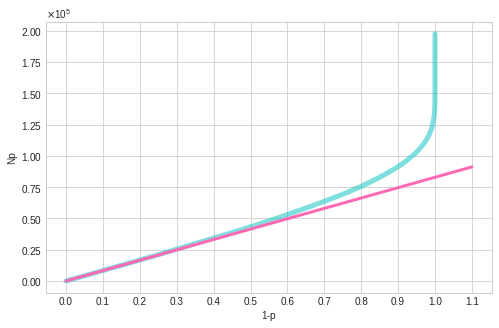

In [15]:
import sqlalchemy
from matplotlib.ticker import ScalarFormatter

fig = plt.figure(figsize=(8,5))
plt.style.use('seaborn-whitegrid')
ax = fig.add_subplot(1,1,1)
ax.set_xticks([i/10 for i in range(0,12,1)])
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style="sci",  axis="y",scilimits=(0,0))
#ax.set_title("")
ax.set_xlabel('1-p')
ax.set_ylabel('Np')

#曲線
x2 = chi2_df["1-p"]
y2 = chi2_df["Np"]
plt.plot(x2, y2, linewidth=5, color="c", alpha=0.5)

#(0,0)と最大値の2点を直線で結ぶ
plt.plot([0, 1.1], [0, a*1.1],  linewidth=3, color="hotpink", alpha=1)
plt.grid(True)
plt.show()

In [16]:
chi2_df[chi2_df.duplicated()] #重複行は無し

,symptom,disease,chi2,p,1-p,Np


In [17]:
#共起ペアを作成し直すための準備（P値は0.05未満のもののみを抽出）

In [18]:
len(chi2_df[chi2_df["p"]<0.05]), len(chi2_df[:9873])

(94377, 9873)

In [19]:
#0.05で切った共起ぺアと共起数をセットにする

#χ二乗検定のp値0.05未満のデータとco_occ_pairをマージさせ、ペア・共起数を抽出する
cutoff_pair = chi2_df[chi2_df["p"]<0.05].merge(co_occ_pair, on=["symptom", "disease"])
cutoff_pair = cutoff_pair.sort_values(by='co_occurrence', ascending=False).reset_index(drop=True)

In [20]:
#カットオフ前後の共起ペアの件数確認 少なくなっているか
print(len(co_occ_pair))
print(len(cutoff_pair))

197466
94377


In [21]:
co_occ_pair.to_csv("ds_pair_m2021.csv", index=False)
cutoff_pair.to_csv("ds_pair_m2021_cut.csv", index=False)

In [24]:
co_occ_pair[:3]

,symptom,disease,co_occurrence
0,Obesity,Obesity,92072
1,Intellectual Disability,Intellectual Disability,33525
2,Seizures,Seizures,25079


In [22]:
print("co_occ_pair:", co_occ_pair["co_occurrence"].sum())
print("cutoff_pair:", cutoff_pair["co_occurrence"].sum())

co_occ_pair: 2631644
cutoff_pair: 2336350


In [23]:
print("co_occ_unique_disease:", co_occ_pair["disease"].nunique())
print("co_occ_unique_symptom:", co_occ_pair["symptom"].nunique())

co_occ_unique_disease: 4679
co_occ_unique_symptom: 385
